# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [2]:
from joblib.testing import param
from pexpect import which
from sklearn.metrics import accuracy_score

from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

## Generating the data

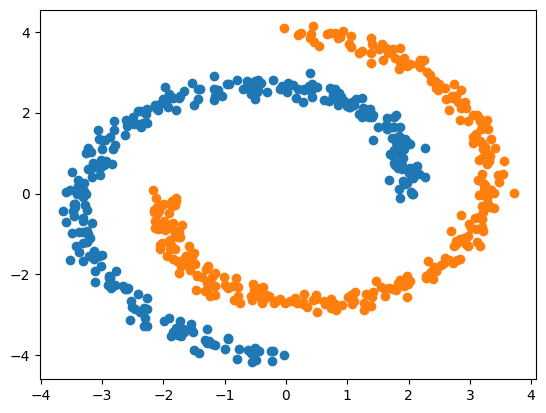

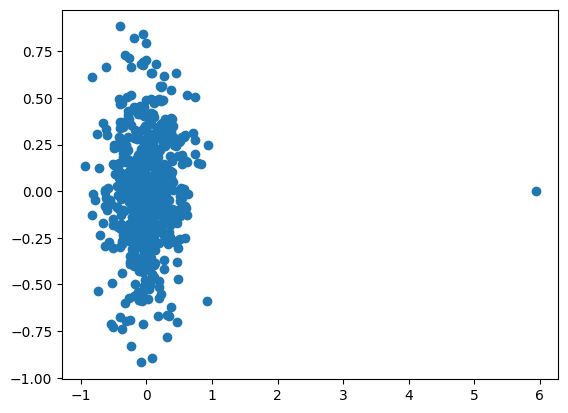

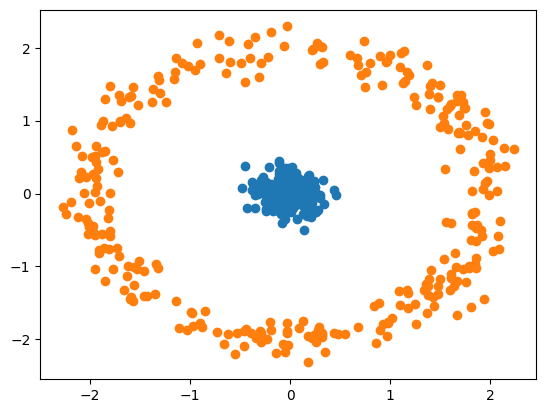

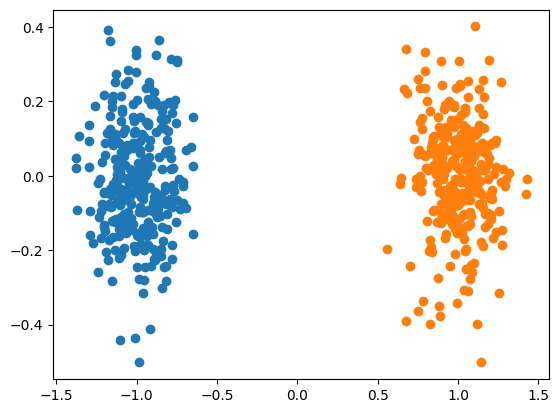

In [3]:
# Example
for fn in [two_moons, worst_case_blob, point_and_circle, blobs]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.: worst_case_blob?

## Building similarity graph

In [4]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0, neighbors_method = "or"):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.exp(-skm.euclidean_distances(X, squared=True)/(2*var))
    similarities[range(n), range(n)] = 0 #remove self similarities 

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = similarities
        W[W < eps] = 0

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        for i in range(n):
            nearest_neighbors_indices = np.argsort(similarities[i,:])[-k:]
            if neighbors_method == "or":
                for j in nearest_neighbors_indices:
                    W[i,j] = similarities[i,j]
            elif neighbors_method == "and":
                for j in nearest_neighbors_indices:
                    if i in np.argsort(similarities[j,:])[-k:]:
                        W[i,j] = similarities[i,j]
            else:
                print("Neighbors method must be either 'or' or 'and'")

    return W

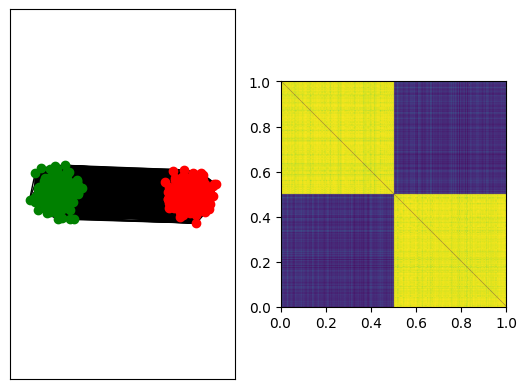

In [5]:
# Example

W = build_similarity_graph(X)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [5]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    diag = np.sum(W, axis=1)
    D = np.diag(diag)
    
    if laplacian_normalization == 'unn':
        L = D - W
    elif laplacian_normalization == 'sym':
        D_inv_sqrt = np.diag(1 / np.sqrt(np.diag(D)))
        L = np.eye(W.shape[0]) - D_inv_sqrt @ W @ D_inv_sqrt
    elif laplacian_normalization == 'rw':
        L = np.eye(W.shape[0]) - np.linalg.inv(D) @ W
    else:
        print("This version of the laplacian matrix is not available")
        
    return L

## Clustering

In [6]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2, cumulative_eigenvalues_threshold = 1e-3):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    eigenvalues, eigenvectors = scipy.linalg.eig(L)
    indices = eigenvalues.argsort()  
    eigenvalues = eigenvalues[indices].real
    eigenvectors = eigenvectors[:,indices].real
        
   
    if chosen_eig_indices is None:
        eigenvalues /= np.sum(eigenvalues)
        cumulative_eigenvalues = np.cumsum(eigenvalues)
        indices = np.sum(cumulative_eigenvalues < cumulative_eigenvalues_threshold)
        if indices <= 1:
            indices = 2
        chosen_eig_indices = np.arange(1,indices)
        
    U = eigenvectors[:, chosen_eig_indices].real
    E = np.diag(eigenvalues[chosen_eig_indices].real)
        

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    Y = KMeans(n_clusters=num_classes).fit_predict(U)
    
    return Y

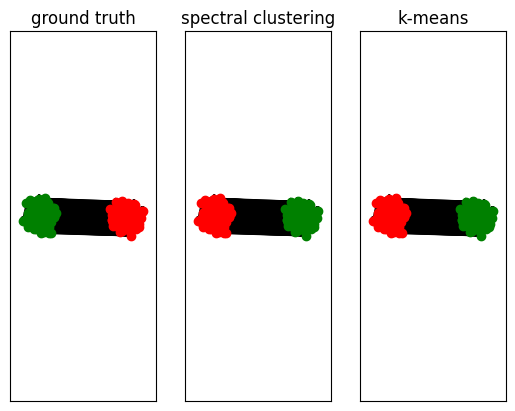

In [8]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [7]:
def parameter_sensitivity():
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None
    
    # Generate data
    X, Y = two_moons(num_samples, 1, 0.02)
    num_classes = len(np.unique(Y))

    """
    Choose candidate parameters
    """
    parameter_type = 'k' # choose between 'k' or 'eps'
    parameter_candidate = np.arange(1, 100, 1)     # the number of neighbours for the graph (if 'k')
                                                            # or the epsilon threshold (if 'eps')
    parameter_performance = []

    for parameter in parameter_candidate:
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.ylabel('Performance (Accuracy score)')
    plt.show()
    
    
    parameter_type = 'eps' # choose between 'k' or 'eps'
    parameter_candidate = np.arange(0.01, 1, 0.05)    # the number of neighbours for the graph (if 'k')
                                                                        # or the epsilon threshold (if 'eps')
    parameter_performance = []

    for parameter in parameter_candidate:
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.ylabel('Performance (Accuracy score)')  # Add label for the y-axis
    plt.show()

## Image segmentation

In [8]:
def image_segmentation(input_img='four_elements.bmp', k = 2, laplacian_normalization = 'unn', chosen_eig_indices = None, num_classes = 1, cumulative_eigenvalues_threshold=1e-3):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes, cumulative_eigenvalues_threshold=cumulative_eigenvalues_threshold)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

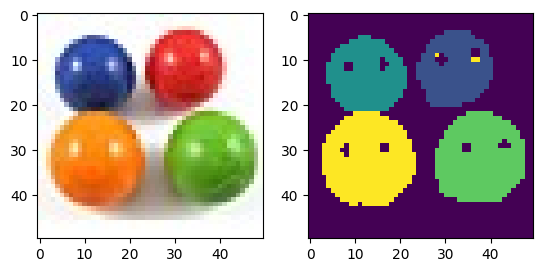

In [11]:
image_segmentation(k=50, laplacian_normalization='unn', num_classes=5, chosen_eig_indices = [0, 1, 2, 3, 4])

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

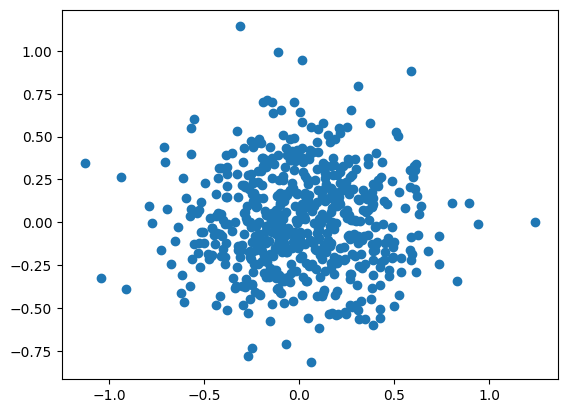

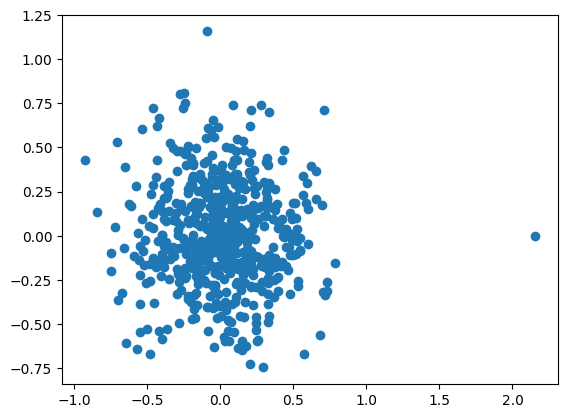

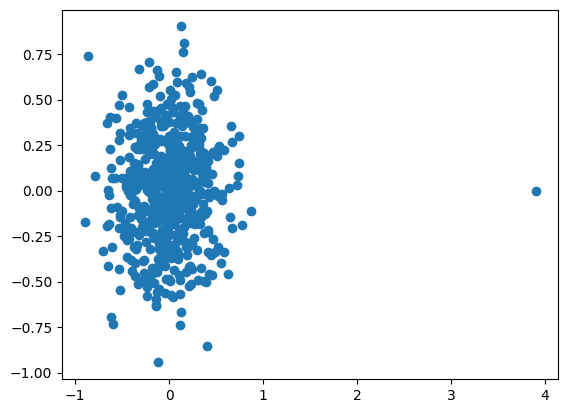

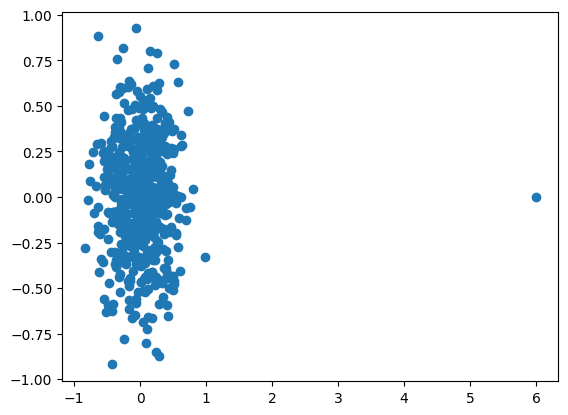

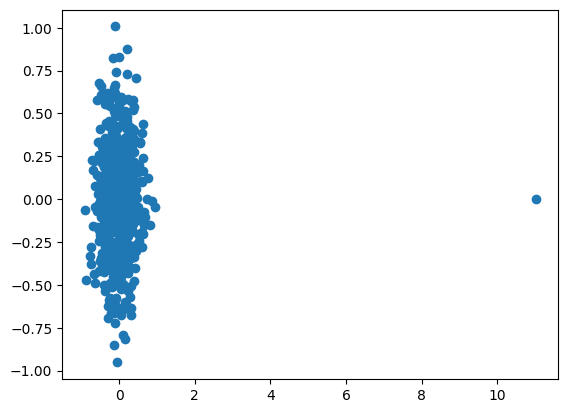

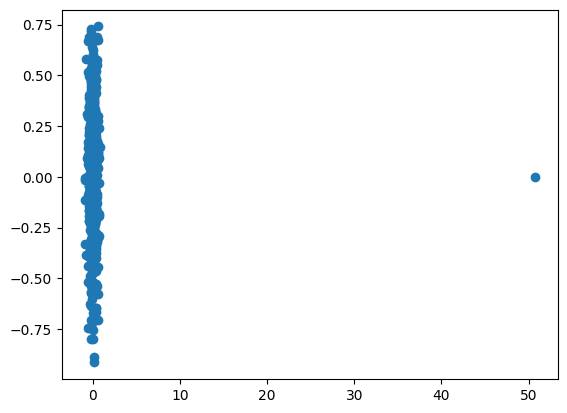

In [146]:
delta_list = [0.1, 1, 3, 5, 10, 50]

for delta in delta_list:
    X, Y = worst_case_blob(num_samples=600, delta=delta)
    plot_clusters(X, Y, fignum=str(f'worst_case_blob_{delta}'))

The first `delta` parameter from the `worst_case_blob` function enable the user to give the distance along the x-axis between an outlier point and the rest of the data which is around zero for the x-axis. Indeed, for `delata=1`, the outlier point is around (2,0), for `delata=3`, the outlier point is around (4,0) etc...
If `delta` is too small we cannot distinguish this special point from the others, however if `delta` is bigger we can distinguish it easily.

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

### Delta = 0.1 ###


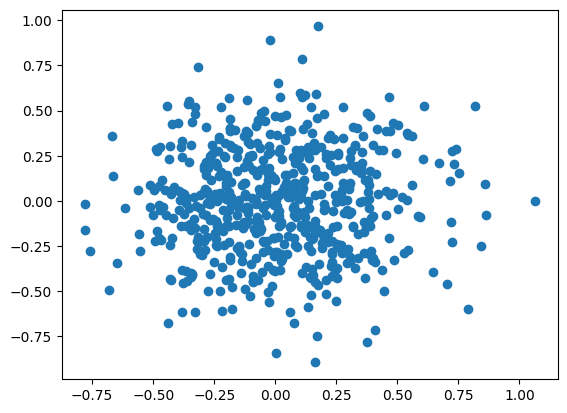

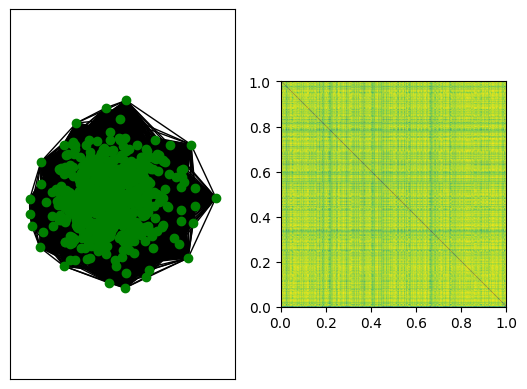

Graph after transformation (eps = 0.9768372243278818)


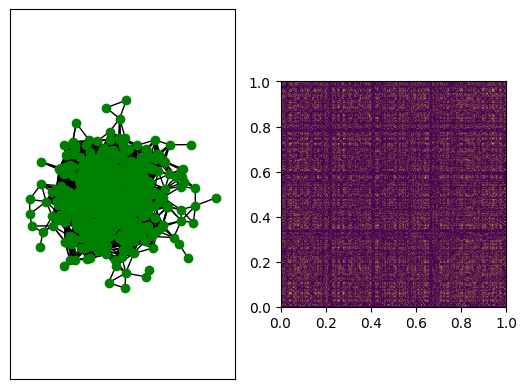

### Delta = 1 ###


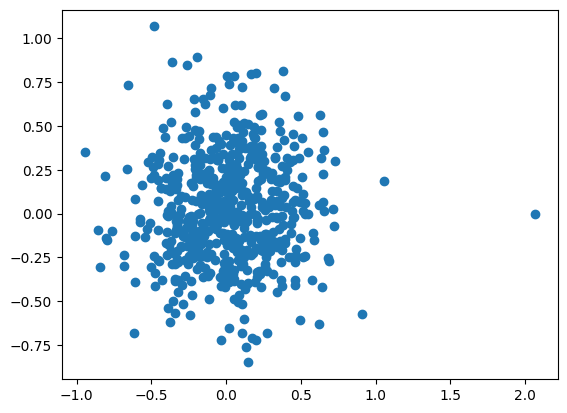

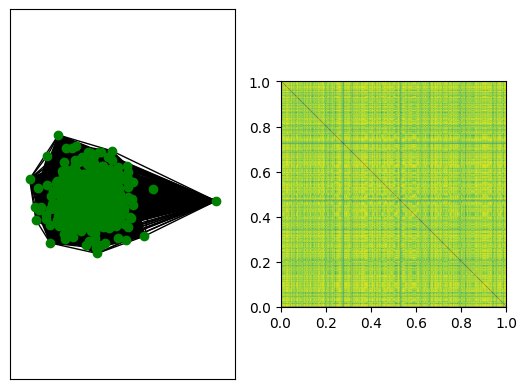

Graph after transformation (eps = 0.5885749727124435)


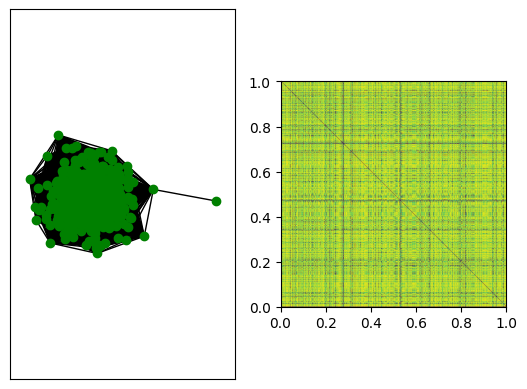

### Delta = 3 ###


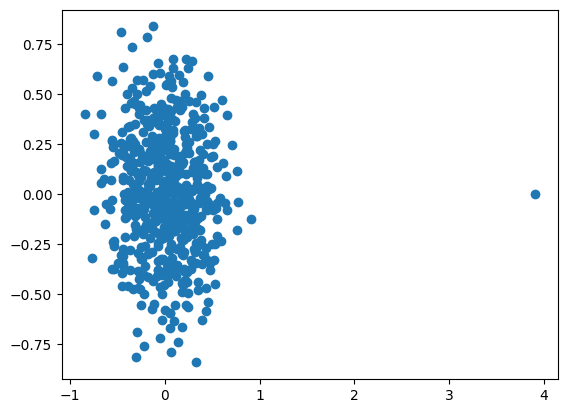

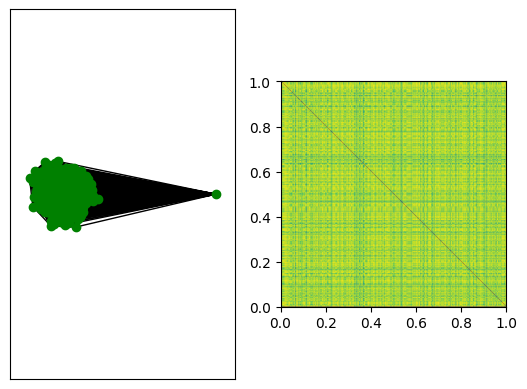

Graph after transformation (eps = 0.01102395042847637)


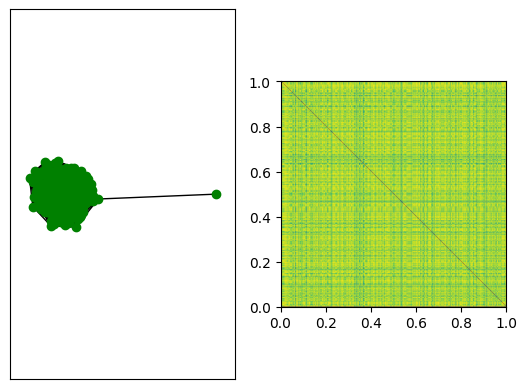

### Delta = 5 ###


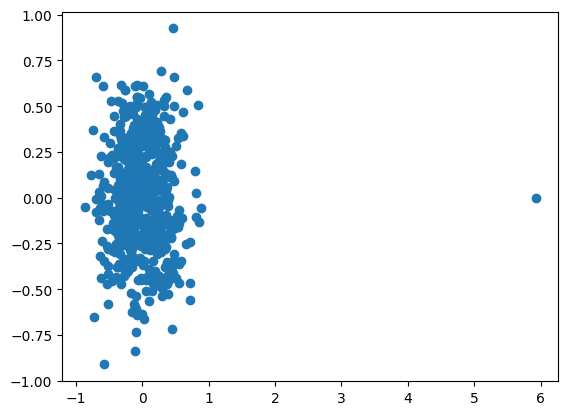

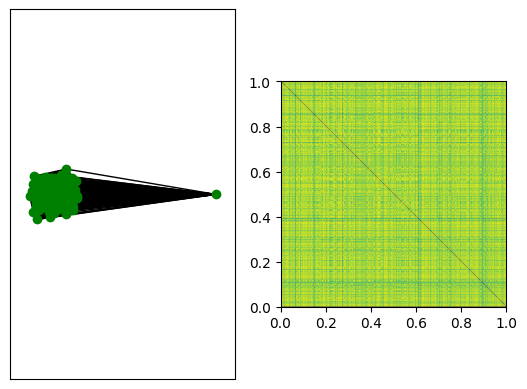

Graph after transformation (eps = 2.96973060078355e-06)


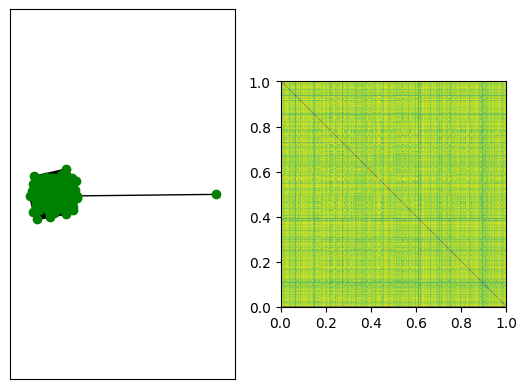

### Delta = 10 ###


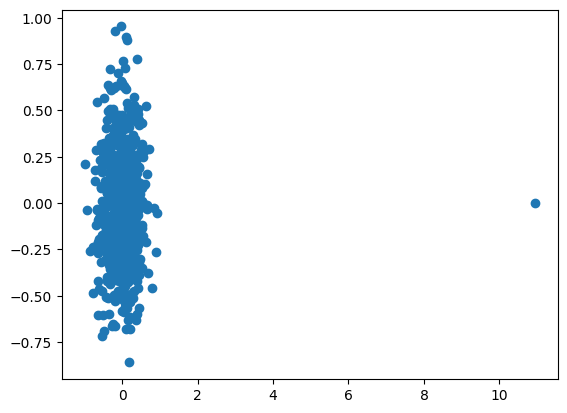

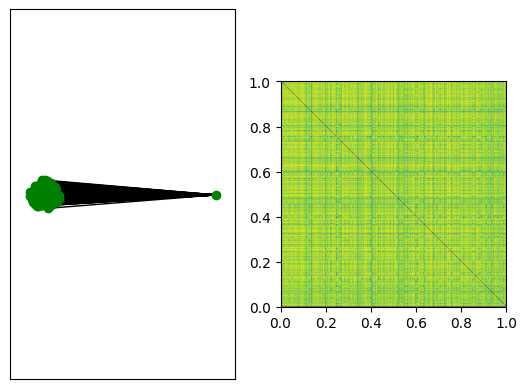

Graph after transformation (eps = 0.9679370494738844)


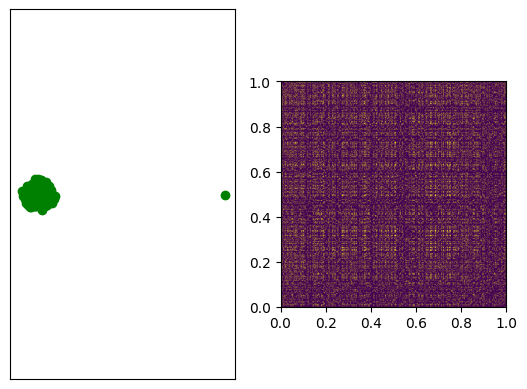

### Delta = 50 ###


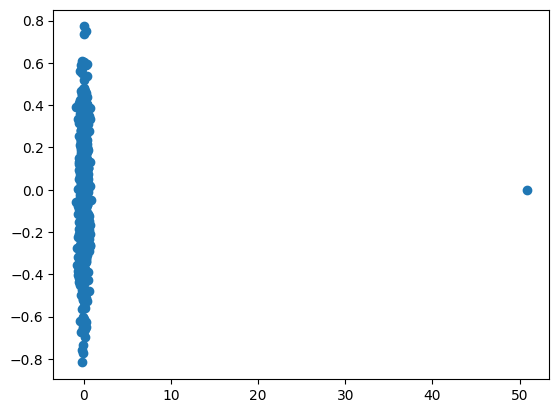

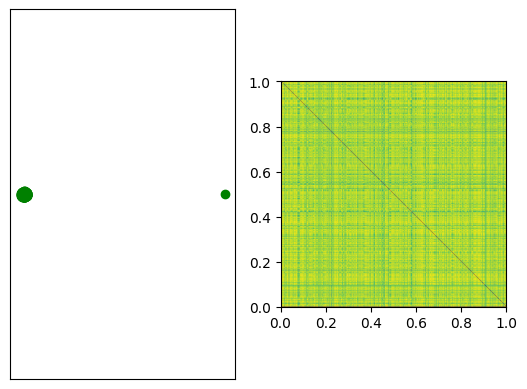

Graph after transformation (eps = 0.964768878578613)


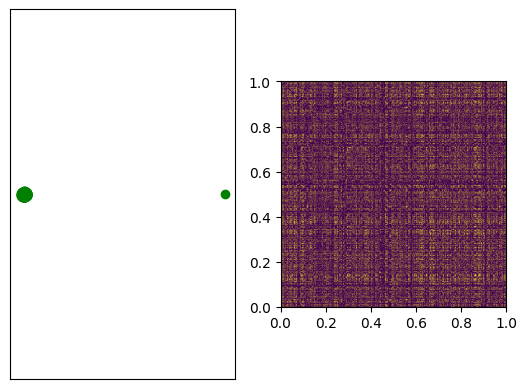

In [147]:
delta_list = [0.1, 1, 3, 5, 10, 50]

for delta in delta_list:
    print(f"### Delta = {delta} ###")
    X, Y = worst_case_blob(num_samples=600, delta=delta)
    plot_clusters(X, Y, fignum=str(f'worst_case_blob_{delta}'))
    
    W = build_similarity_graph(X)
    
    plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W
    T = min_span_tree(-W)
    T = W[T]
    eps = np.min(T)
    print(f"Graph after transformation (eps = {eps})")
    new_W = build_similarity_graph(X, eps = eps)
    
    plot_graph_matrix(X, Y, new_W)

A minimum spanning tree (MST) is a subset of edges from the original graph that connects all vertices, it forms a tree (no cycles) and it has the minimum possible total edge weight. The goal of this question is to select a value of $\epsilon$ while keeping the graph connected. To do so, we compute the MST on $-W$ in order to have the minimum possible weight (which corresponds to the highest similarities). Then, we select $\epsilon$ as the minimum value of the MST, which will ensure the graph is still connected.

The method explained before was applied on `worst_case_blob` while varying `delta`. We can observe that it works well for `delta = 0.1 or 1`, indeed the graph is still connected and the value of $\epsilon$ is above 0.6, it means that a lot of edges have been removed. For `delta = 3 or 5`, it doesn't work so well, indeed this time the value of $\epsilon$ is below 0.1, the graph hasn't changed a lot, just a few edges have been removed. Finally, for `delta = 10 or 50`, it doesn't work anymore, indeed the graphs are not connected anymore. Therefore, we can conclude that our approach doesn't work when `delta` is too high, it corresponds to data distribution with outliers far from the global data distribution.

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

#### Epsilon = 0.1 ####


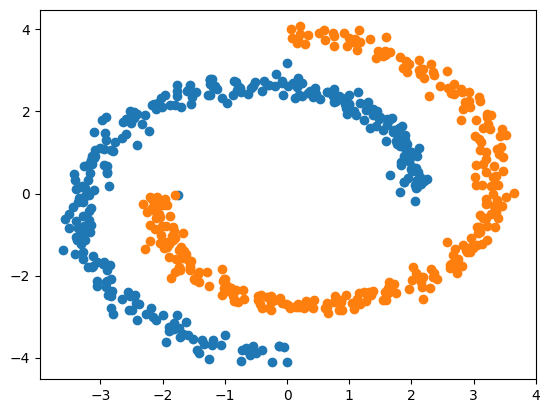

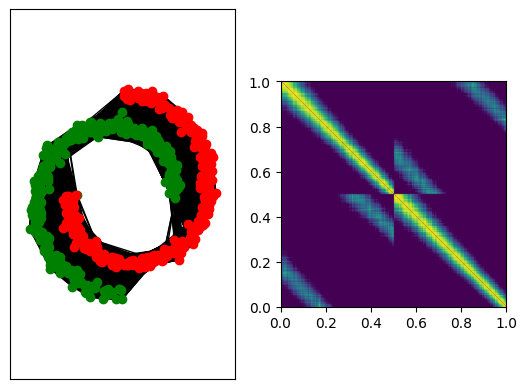

#### Epsilon = 0.5 ####


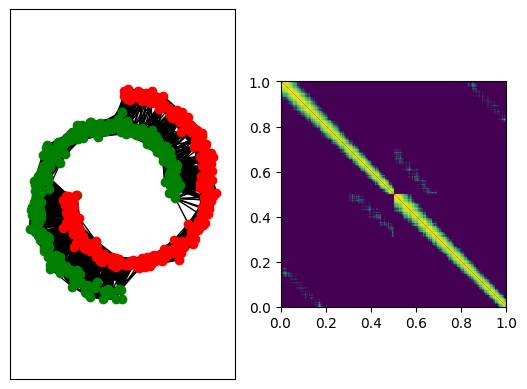

#### Epsilon = 0.9 ####


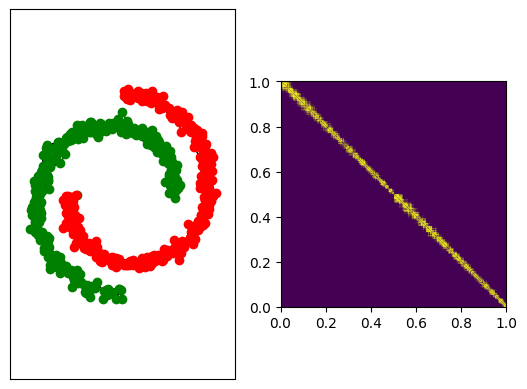

#### K = 2 ####


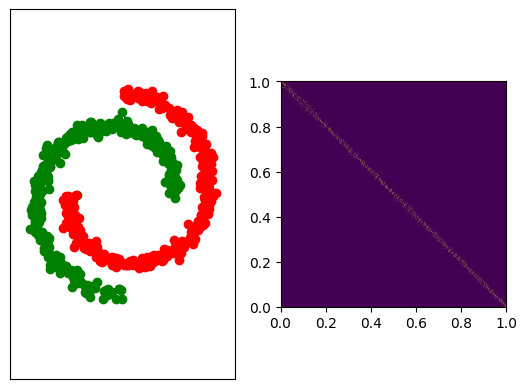

#### K = 10 ####


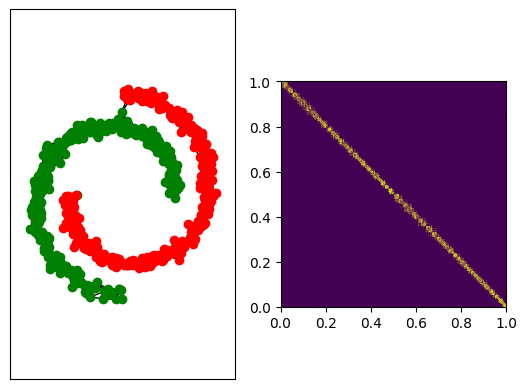

#### K = 50 ####


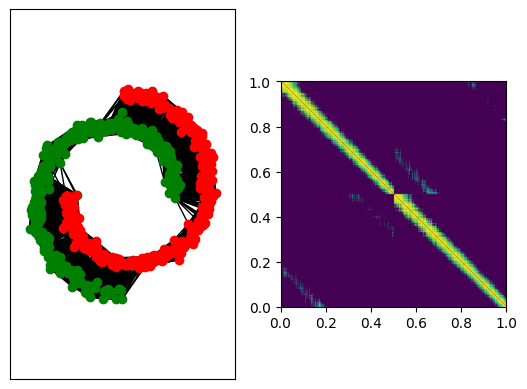

#### K = 150 ####


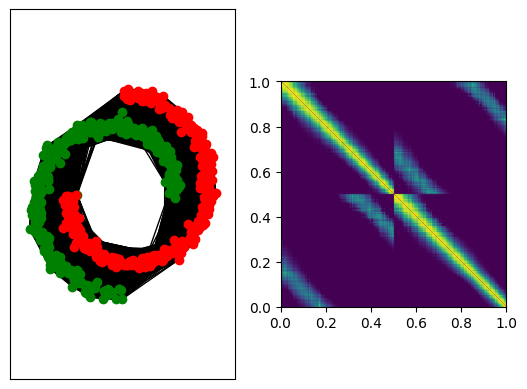

#### Epsilon = 0.1 ####


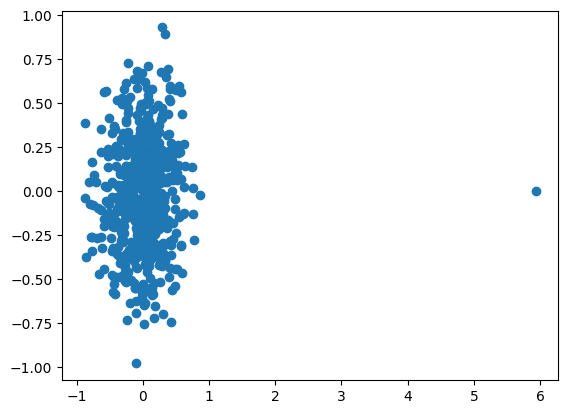

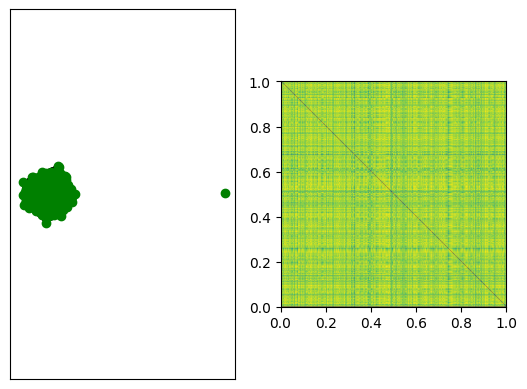

#### Epsilon = 0.5 ####


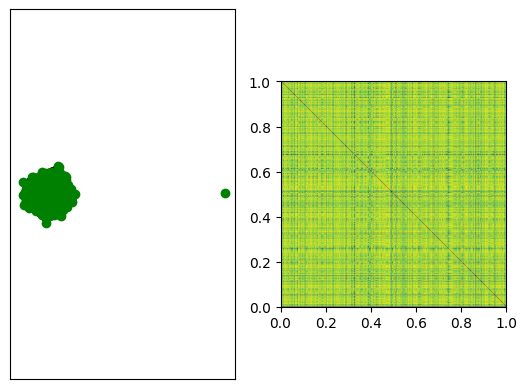

#### Epsilon = 0.9 ####


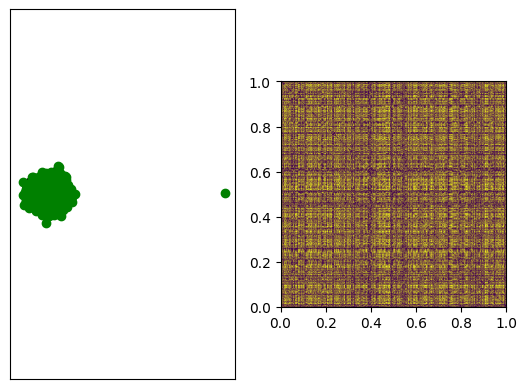

#### K = 2 ####


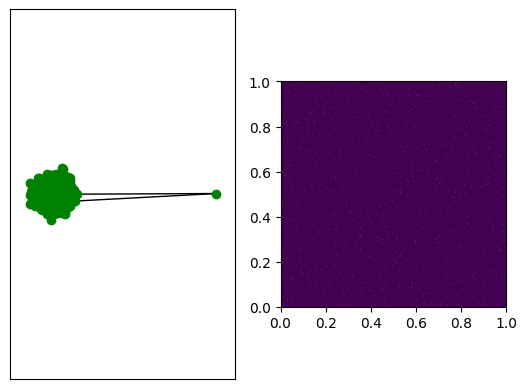

#### K = 10 ####


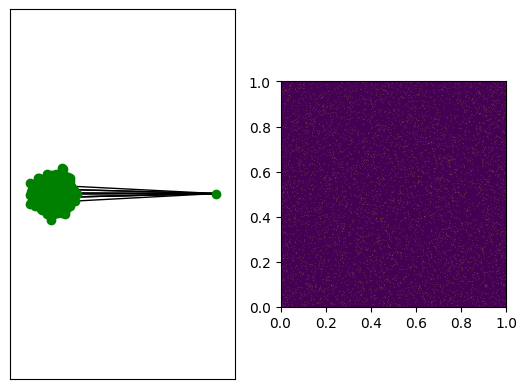

#### K = 50 ####


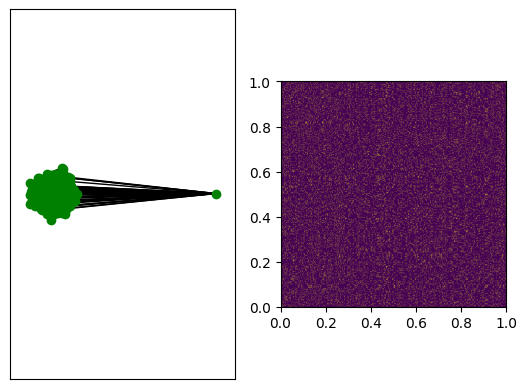

#### K = 150 ####


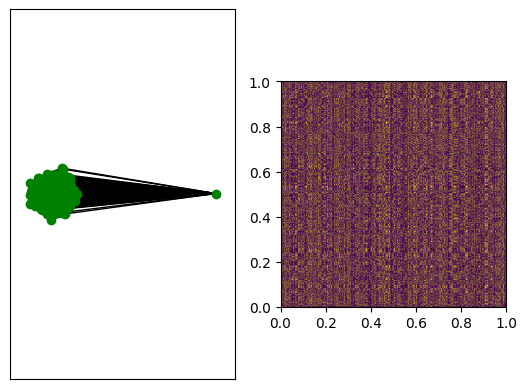

#### Epsilon = 0.1 ####


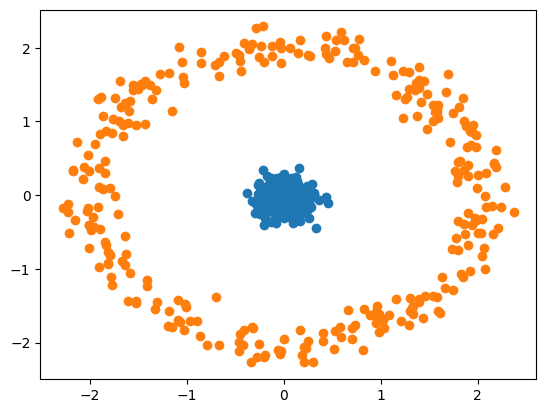

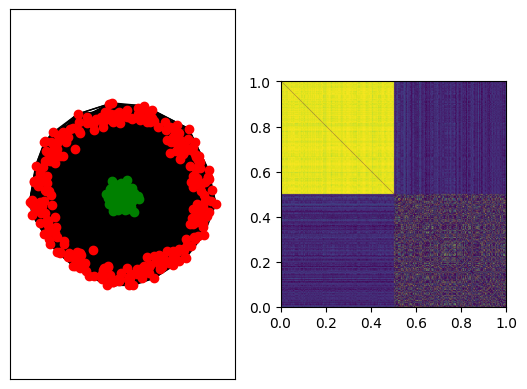

#### Epsilon = 0.5 ####


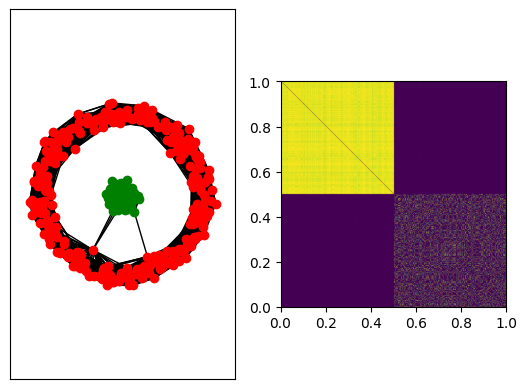

#### Epsilon = 0.9 ####


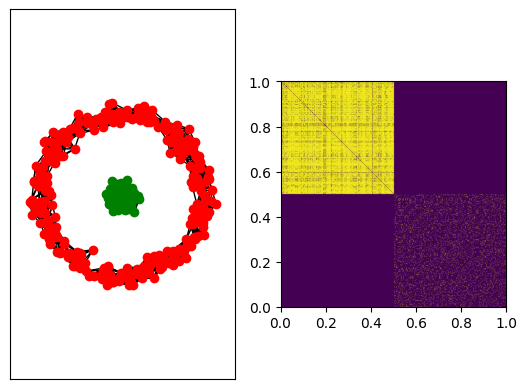

#### K = 2 ####


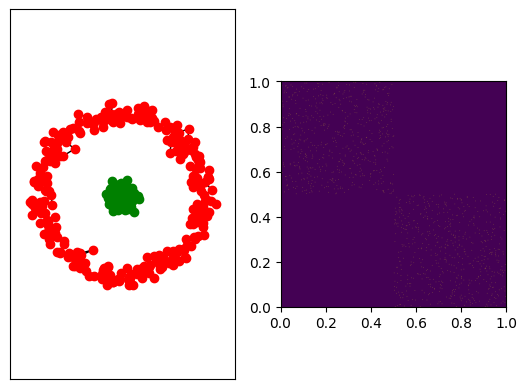

#### K = 10 ####


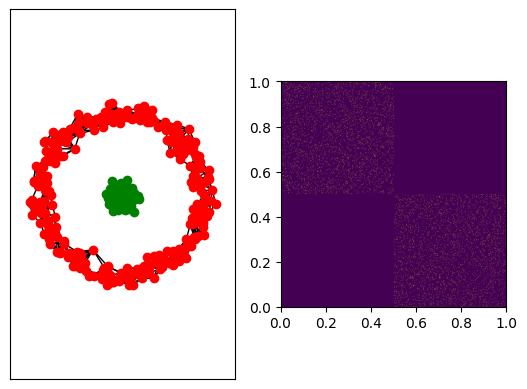

#### K = 50 ####


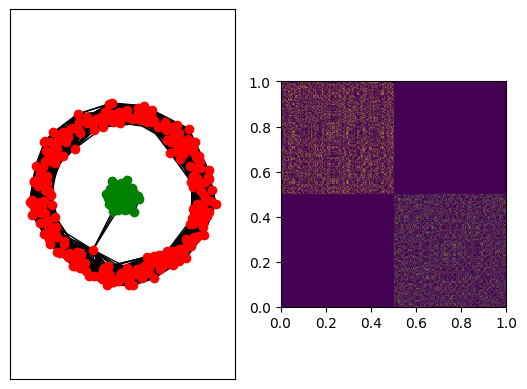

#### K = 150 ####


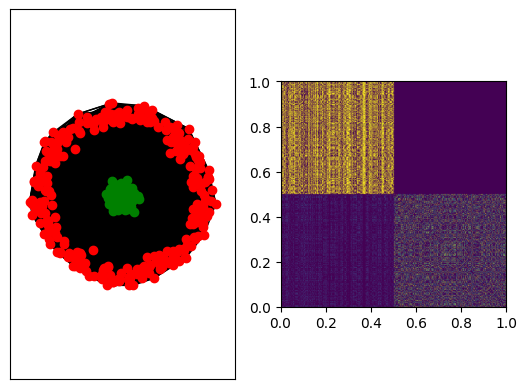

#### Epsilon = 0.1 ####


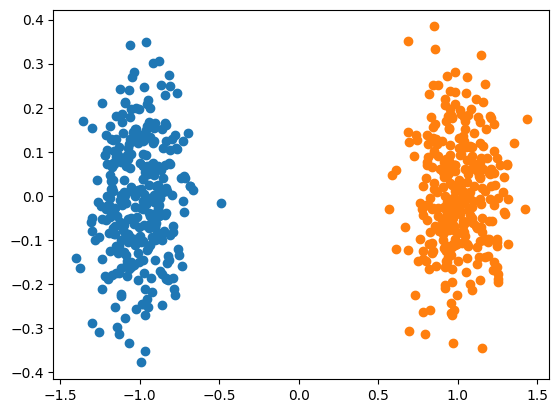

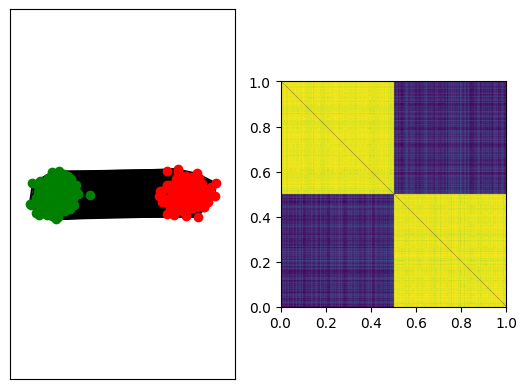

#### Epsilon = 0.5 ####


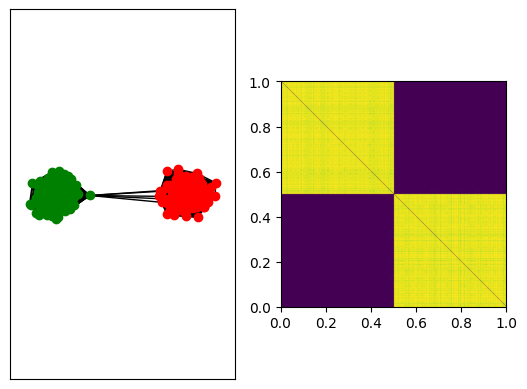

#### Epsilon = 0.9 ####


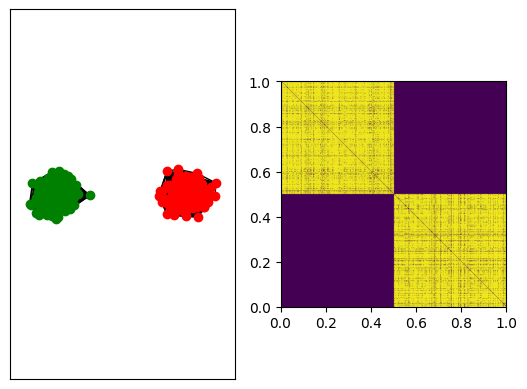

#### K = 2 ####


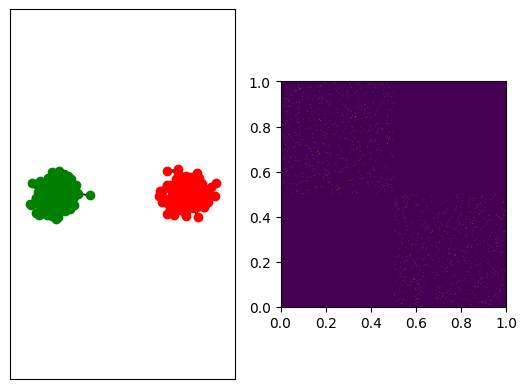

#### K = 10 ####


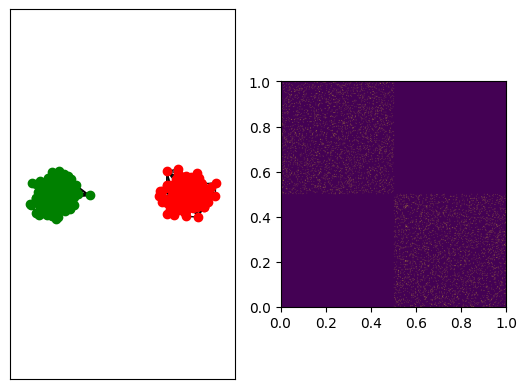

#### K = 50 ####


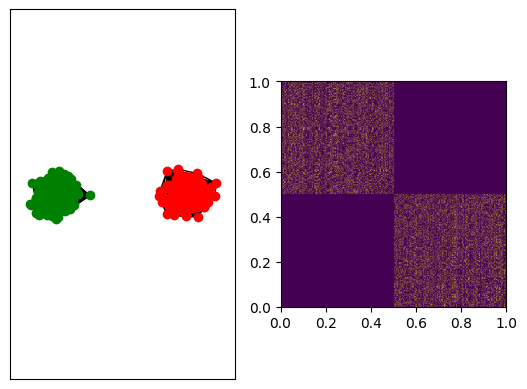

#### K = 150 ####


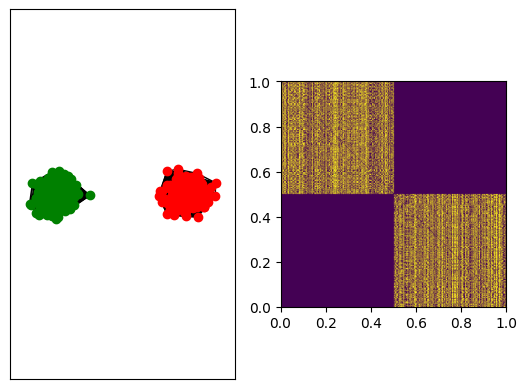

In [148]:
epsilon_list = [0.1, 0.5, 0.9]
k_list = [2, 10, 50, 150]

for fn in [two_moons, worst_case_blob, point_and_circle, blobs]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
    for eps in epsilon_list:
        print(f"#### Epsilon = {eps} ####")
        W = build_similarity_graph(X, eps = eps)
        plot_graph_matrix(X, Y, W)
    
    for k in k_list:
        print(f"#### K = {k} ####")
        W = build_similarity_graph(X, k=k)
        plot_graph_matrix(X, Y, W)


Building a connected graph is crucial, as the graph cut methods studied in class are more efficient when applied to connected graphs. Connectivity is essential for dividing the graph into meaningful clusters. When the graph is disconnected, each subgraph must be clustered separately, which complicates the process and can reduce overall performance. 

For the creation of connected graphs, it depends on the distribution of the data and on the value of $\epsilon$ and k:

- For the two_moons and point_and_circle dataset, both methods seems to be able to produce connected graphs.
- For the worst_case_blob dataset, the k-NN graphs are better and can create a connected graph. It doesn't work for the $\epsilon$-graph because of the outlier point (maybe it could work for a very very low value of $\epsilon$)
- For the blobs dataset, the $\epsilon$-graph can create connected graph in contrary of the k-NN-graph, this is because of the presence of two dense and separated data region.




### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

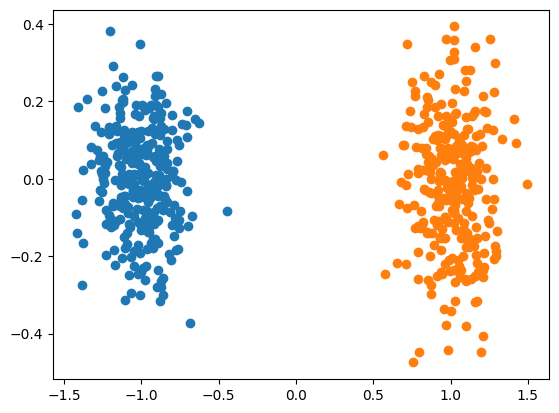

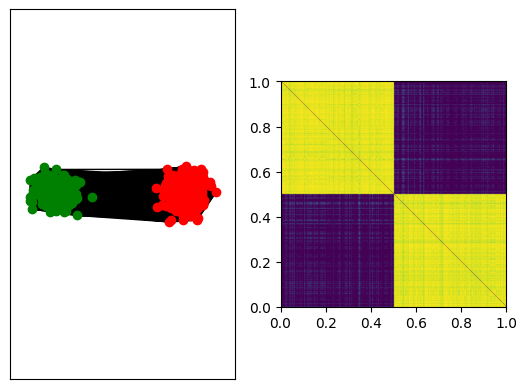

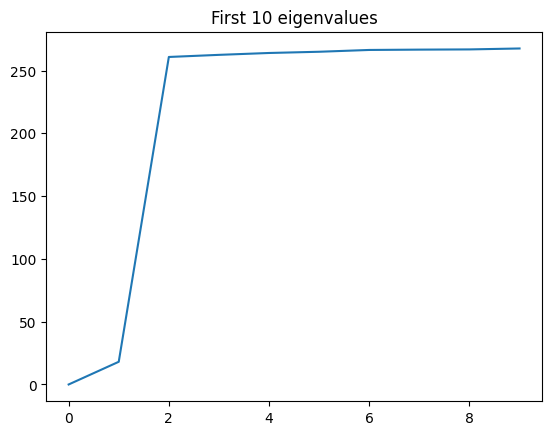

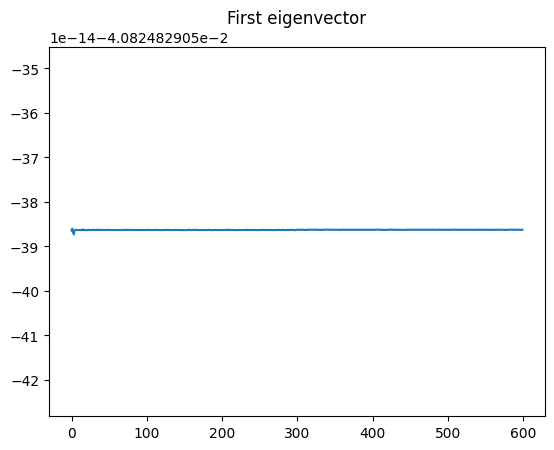

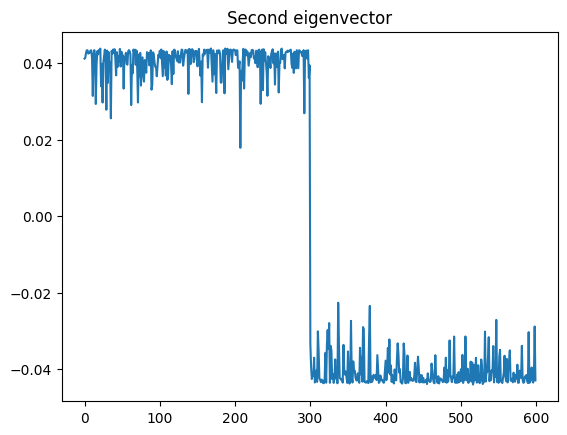

Clustering with built-in KMeans method


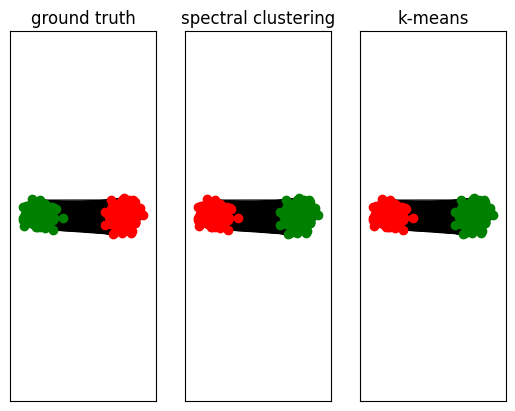

Accuracy score: 0.0
Clustering with threshold method


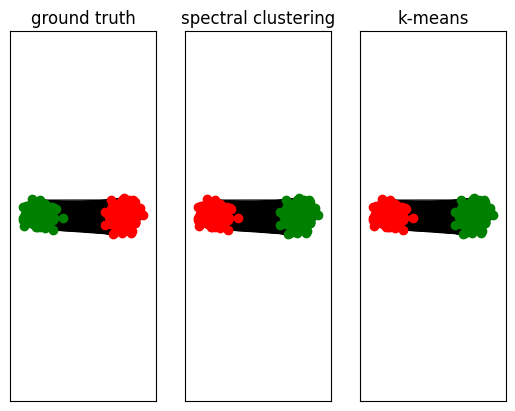

Accuracy score: 1.0


In [149]:
num_classes = 2
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

eps = 0.20
W = build_similarity_graph(X, eps = eps)
plot_graph_matrix(X, Y, W)

L = build_laplacian(W)

eigenvalues, eigenvectors = scipy.linalg.eig(L)
indices = eigenvalues.argsort()  
eigenvalues = eigenvalues[indices].real
U = eigenvectors[:,indices].real
E = np.diag(eigenvalues)

plt.title("First 10 eigenvalues")
plt.plot(eigenvalues[:10])
plt.show()
plt.figure()
plt.plot(U[:,0])
plt.title("First eigenvector")
plt.show()
plt.figure()
plt.title("Second eigenvector")
plt.plot(U[:,1])
plt.show()

chosen_eig_indices = [1] #second eigenvector
U = U[:, chosen_eig_indices]

### Kmeans method
print("Clustering with built-in KMeans method")
Y_sc = spectral_clustering(L, chosen_eig_indices)  #Use Kmeans to cluster
plot_clustering_result(X, Y, W, Y_sc, KMeans(n_clusters=num_classes).fit_predict(X))
print("Accuracy score:", skm.accuracy_score(Y, Y_sc))

### Threshold separation method
print("Clustering with threshold method")
threshold = 0
Y_sc = (U>threshold).astype(int)
plot_clustering_result(X, Y, W, Y_sc, KMeans(n_clusters=num_classes).fit_predict(X))
print("Accuracy score:", skm.adjusted_rand_score(Y, Y_sc.ravel()))  # to avoid a score of zero if clusters are swapped

We choose to have a connected graph, therefore, the zero eigenvalue has a multiplicity of 1 (number of connected components) and its corresponding eigenvector is a constant vector as we can see on the graphs above. This eigenvector isn't useful to be able to do discrimination between two possible classes. Therefore, we use the second eigenvector which seems to separate the data into two clusters (here in our case we need two clusters so its perfect). Then, to compute the clustering assignment with this second eigenvector, we have several possibilities, the first one is to use a threshold and cluster the data depending on their value from the threshold. It will construct a binary vector where values corresponds to clusters. In this case, we obtain an accuracy score of 100%. The other methods is to use the KMeans algorithm to cluster the data points automatically, in this case, we also obtain an accuracy score of 100%. Both methods work in this setting.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

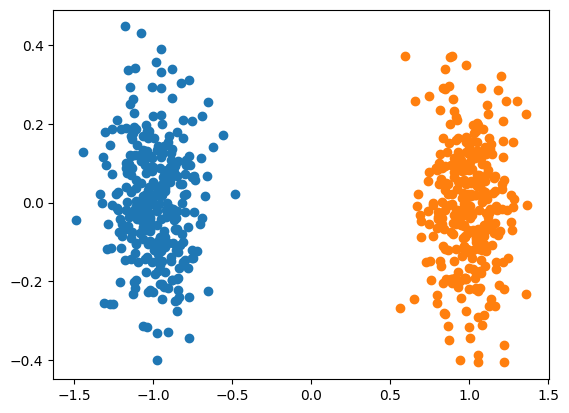

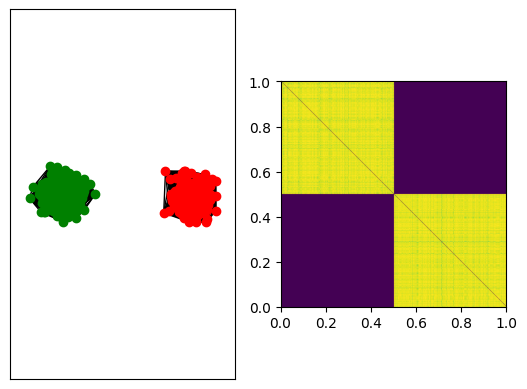

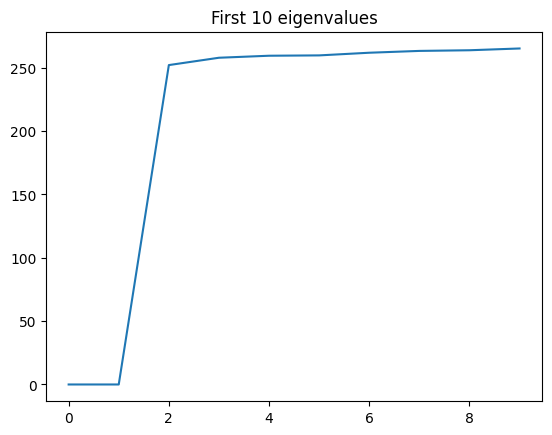

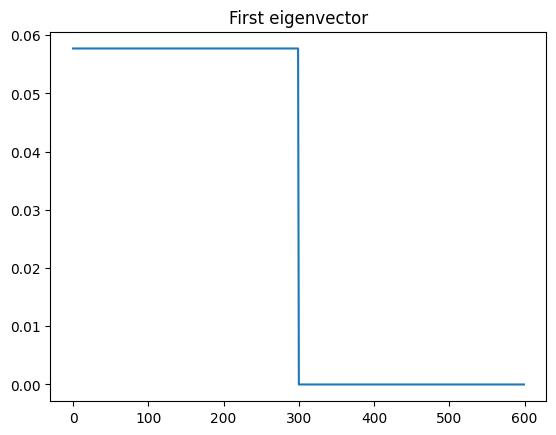

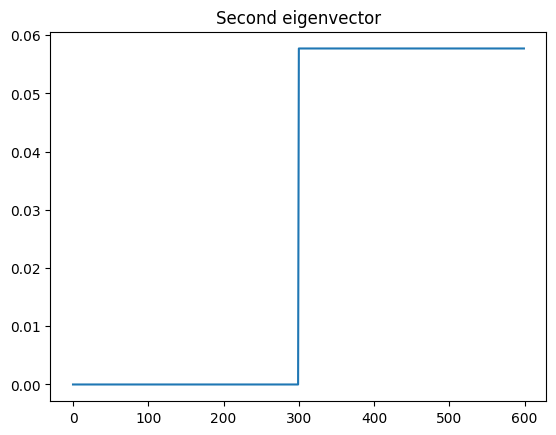

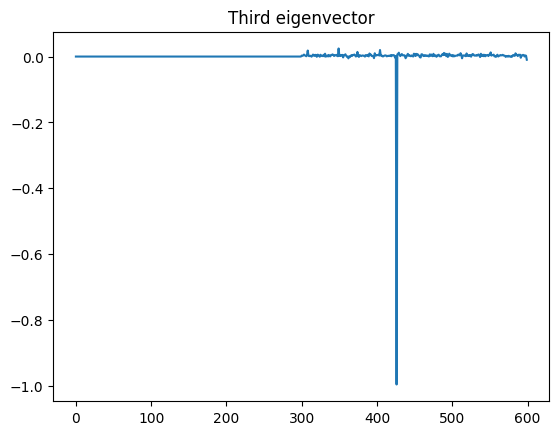

Clustering with built-in KMeans method


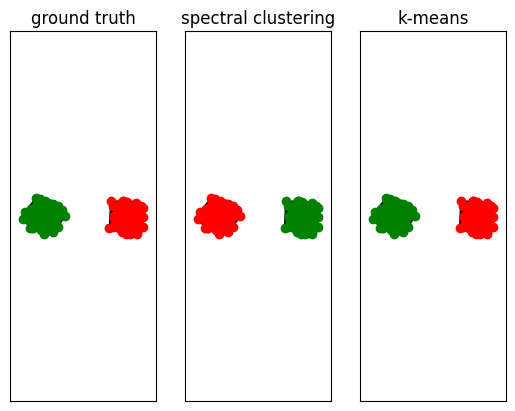

Accuracy score: 1.0
Clustering with threshold method


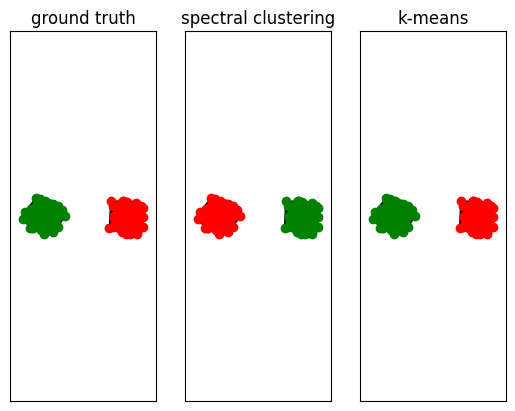

Accuracy score: 1.0


In [150]:
num_classes = 2
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

eps = 0.60
W = build_similarity_graph(X, eps = eps)
plot_graph_matrix(X, Y, W)

L = build_laplacian(W)

eigenvalues, eigenvectors = scipy.linalg.eig(L)
indices = eigenvalues.argsort()  
eigenvalues = eigenvalues[indices].real
U = eigenvectors[:,indices].real
E = np.diag(eigenvalues)

plt.title("First 10 eigenvalues")
plt.plot(eigenvalues[:10])
plt.show()
plt.figure()
plt.plot(U[:,0])
plt.title("First eigenvector")
plt.show()
plt.figure()
plt.title("Second eigenvector")
plt.plot(U[:,1])
plt.show()
plt.figure()
plt.title("Third eigenvector")
plt.plot(U[:,2])
plt.show()

chosen_eig_indices = [0] #second eigenvector
U = U[:, chosen_eig_indices]

### Kmeans method
print("Clustering with built-in KMeans method")
Y_sc = spectral_clustering(L, chosen_eig_indices)  #Use Kmeans to cluster
plot_clustering_result(X, Y, W, Y_sc, KMeans(n_clusters=num_classes).fit_predict(X))
print("Accuracy score:", skm.adjusted_rand_score(Y, Y_sc.ravel()))

### Threshold separation method
print("Clustering with threshold method")
threshold = 0
Y_sc = (U>threshold).astype(int)
plot_clustering_result(X, Y, W, Y_sc, KMeans(n_clusters=num_classes).fit_predict(X))
print("Accuracy score:", skm.adjusted_rand_score(Y, Y_sc.ravel()))  # to avoid a score of zero if clusters are swapped

This time, the graph has two connected components, therefore the multiplicity of the zero eigenvalue is equal to two and the two corresponding eigenvectors are not constant vectors. They both have the same shape and both can be used to cluster the data as we can see on the graphs above. We obtain as before an accuracy score of 100%. 

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

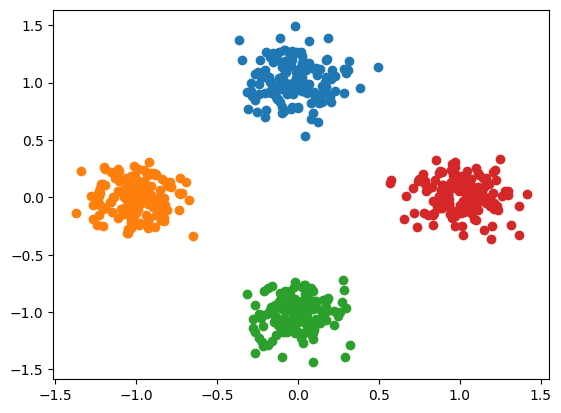

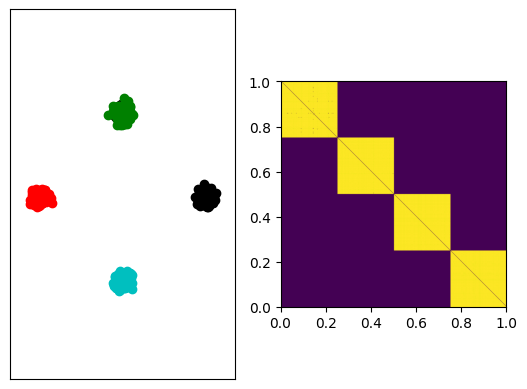

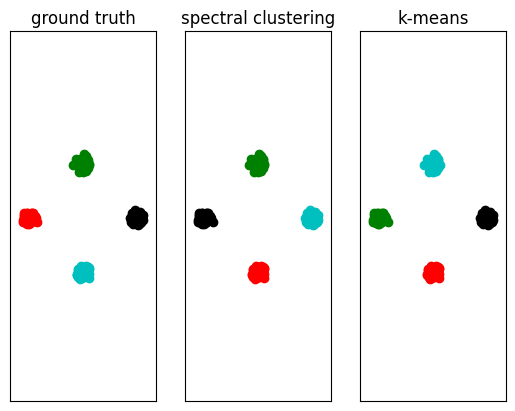

Accuracy score: 1.0


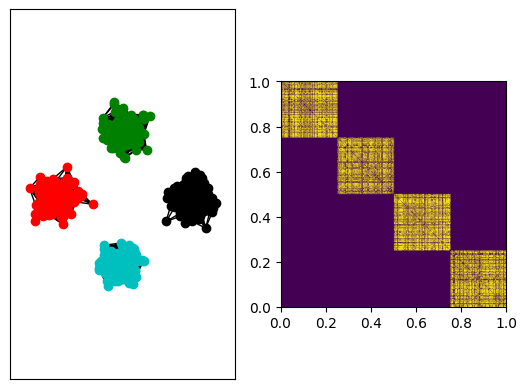

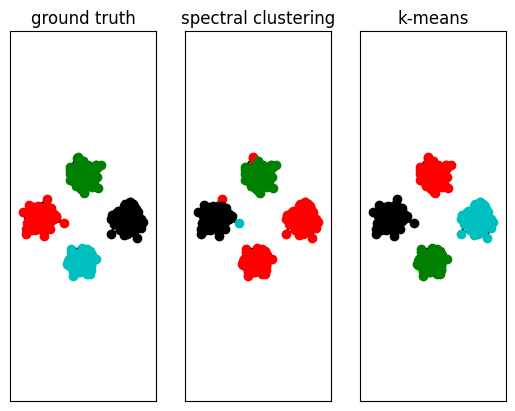

Accuracy score: 0.6948115583589934


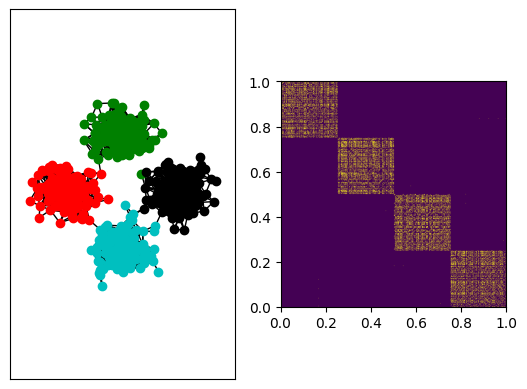

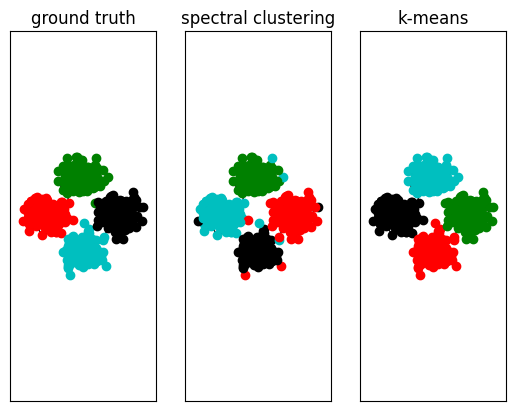

Accuracy score: 0.9514823880741388


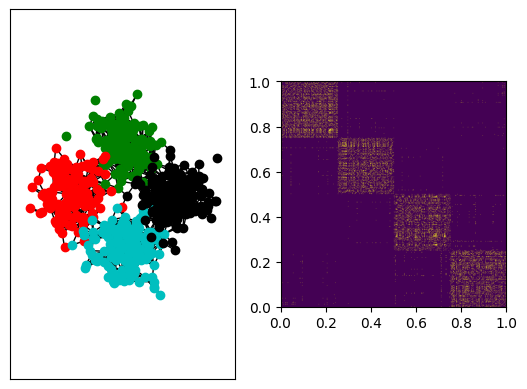

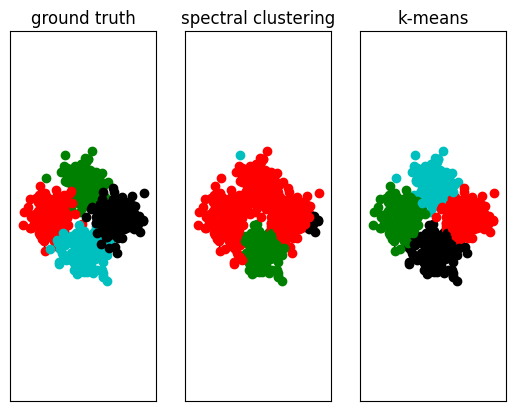

Accuracy score: 0.23026136105636769


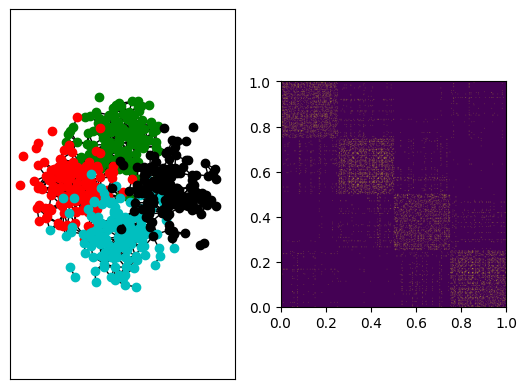

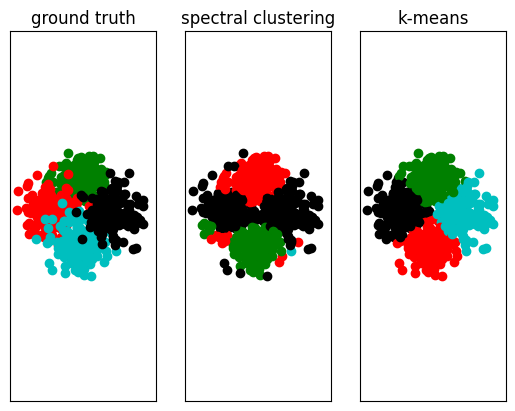

Accuracy score: 0.3958144708536561


In [151]:
num_classes = 4
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

blob_var_list = [0.05, 0.15, 0.25, 0.35, 0.45]
eps = 0.96
for var in blob_var_list:
    X, Y = blobs(num_samples=600, n_blobs=4, blob_var=var)
    W = build_similarity_graph(X, eps = eps)
    plot_graph_matrix(X, Y, W)
    
    L = build_laplacian(W)
    
    Y_sc = spectral_clustering(L, chosen_eig_indices=None, num_classes = num_classes)
    plot_clustering_result(X, Y, W, Y_sc, KMeans(n_clusters=num_classes).fit_predict(X))
    print("Accuracy score:", skm.adjusted_rand_score(Y, Y_sc.ravel()))

My strategy to select meaningful eigenvectors for clustering is first to sort the eigenvalues of the laplacian matrix of the graph and their associated eigenvectors such that $\lambda_1 \leq \cdots \leq \lambda_n$, then to select the first $m < n$ eigenvectors ($x_i$ associated with the eigenvalues $\lambda_i$) such that $\frac{\sum_{i=0}^m \lambda_i}{\sum_{i=0}^n \lambda_i } < threshold$ where $threshold$ is a parameter chosen here to be 10e-3. It means that we select eigenvectors corresponding to small eigenvalues. The selected eigenvectors are then used to do clustering with KMeans.


By testing our strategy on different variance values for the 4 blobs dataset, we observe that when the variance is increasing (blobs can overlap), our strategy struggles to create 4 clusters correctly. On the other hand, when the variance is sufficiently low, our strategy seems to work well!

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

When I built the cluster assignment in questions 2.1 and 2.2, I used both methods. The thresholding method could be used because I always had the number of clusters specified. So, I could keep the first eigenvectors and use it for clustering.
But in the case when the number of clusters is not known like in image segmentation, the KMeans method could be better: we can use the elbow method for example to choose the appropriate number of clusters. Moreover, KMeans is easily generalizable for more than one vector in contrary of the thresholding method.
The main advantage of thresholding is that it is faster and simpler, but it cannot be used in many cases as KMeans which is more general (multidimensional vectors).

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

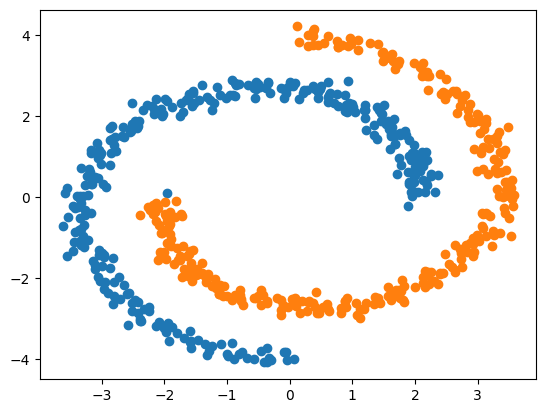

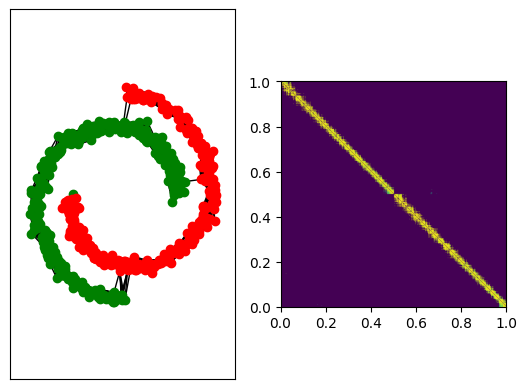

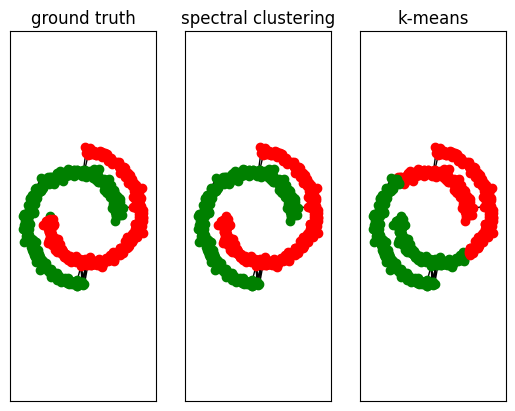

Accuracy score: 0.99333331487675


In [158]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

k = 20
W = build_similarity_graph(X, k = k)
plot_graph_matrix(X, Y, W)

L = build_laplacian(W)

Y_sc = spectral_clustering(L, chosen_eig_indices=None, num_classes = 2, cumulative_eigenvalues_threshold=10e-6)
plot_clustering_result(X, Y, W, Y_sc, KMeans(n_clusters=2).fit_predict(X))
print("Accuracy score:", skm.adjusted_rand_score(Y, Y_sc.ravel()))

It seems that our spectral clustering gives not the same results as the KMeans algorithms. Indeed, Kmeans algorithm seems not to be a good algorithm for this type of data (density based method like DBSCAN should be better), it separates the data into two clusters but not as expected. Indeed, it separates the data where there are few edges between two parts of the graph. This is because KMeans is based on euclidian distance and centroids of the clusters and does not consider the shape of the data.
 
On the other hand our spectral clustering method seems to work better, it separates the data the way we want even if there are some errors around the places where it keeps the graph connected. Indeed, spectral clustering is designed to group data that are connected but not necessarily convex data as it the case for KMeans. 

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

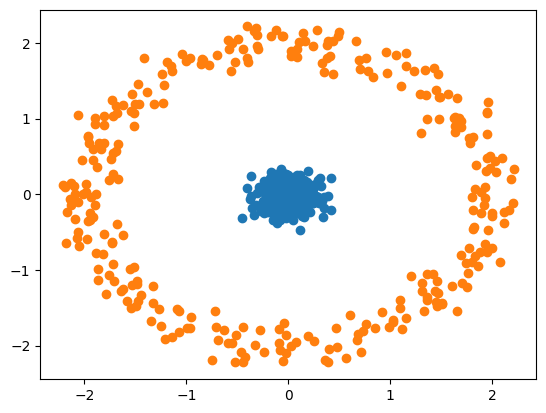

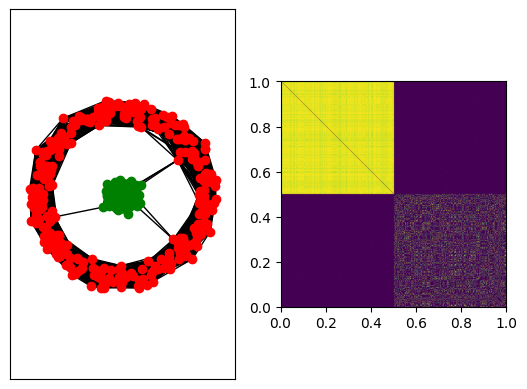

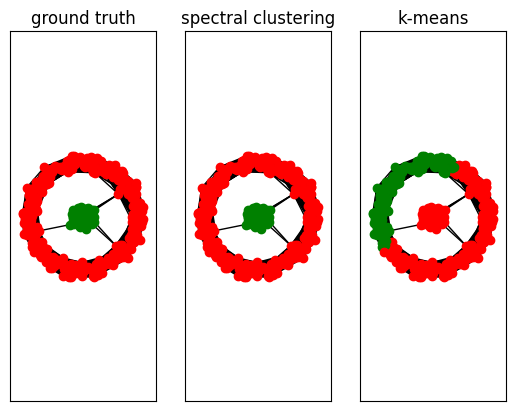

Accuracy score: 1.0


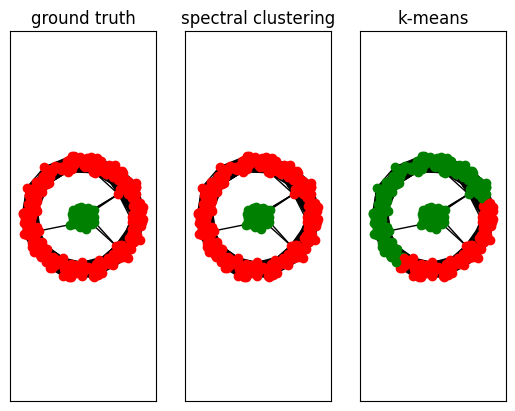

Accuracy score: 1.0


In [19]:
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

eps = 0.48
W = build_similarity_graph(X, eps= eps)
plot_graph_matrix(X, Y, W)

L = build_laplacian(W, laplacian_normalization="unn")

Y_sc = spectral_clustering(L, chosen_eig_indices=None, num_classes = 2, cumulative_eigenvalues_threshold=1e-5)
plot_clustering_result(X, Y, W, Y_sc, KMeans(n_clusters=2).fit_predict(X))
print("Accuracy score:", skm.adjusted_rand_score(Y, Y_sc.ravel()))


L2 = build_laplacian(W, laplacian_normalization="rw")

Y_sc = spectral_clustering(L2, chosen_eig_indices=None, num_classes = 2, cumulative_eigenvalues_threshold=1e-5)
plot_clustering_result(X, Y, W, Y_sc, KMeans(n_clusters=2).fit_predict(X))
print("Accuracy score:", skm.adjusted_rand_score(Y, Y_sc.ravel()))

I didn't see any difference between the choice of the two Laplacian matrix with the chosen hyperparameters here. However, the main difference between the normal Laplacian and the random-walk regularized Laplacian is how they handle the degree of nodes in the graph. The regularized (random-walk) Laplacian normalizes by the degree of the nodes, which makes it less sensitive to regions of the graph where nodes have high degrees. In contrast, the normal Laplacian can be more sensitive to areas of the graph with dense connections (high-degree nodes). The normal Laplacian should struggle to properly separate the circle from the central points, especially if the points are densely clustered.

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

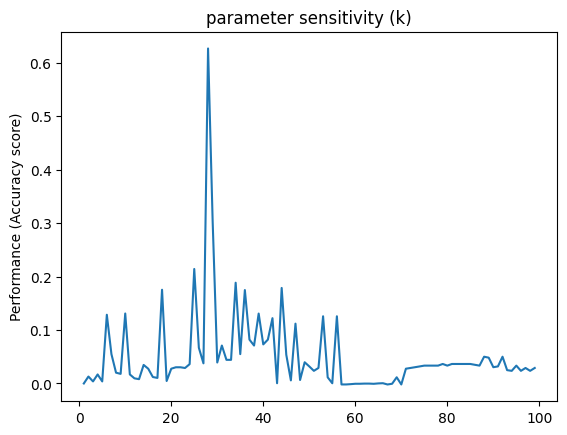

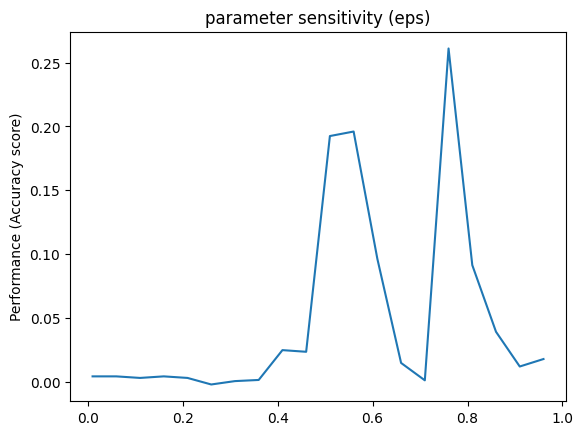

In [173]:
parameter_sensitivity()

The spectral clustering method is highly related with the value of $k$ or $\epsilon$ (depending on the building graph method) as we can see on the two graphs above. Indeed, depending on the value of $k$ or $\epsilon$, we can get very good results as well as very bad results. Moreover, for a small change of the value of $k$ or $\epsilon$, the accuracy results can change drastically. Therefore, the spectral clustering method is very sensitive to the choice of the $k$/$\epsilon$ value.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

If we did not have access to the ground truth labels, we could not use the accuracy score to verify if our clusters are well defined or not. Hoppefully, some metrics have been designed to verify the natural properties of good clusters: no overlapping between clusters, samples in a same clusters are similar and samples in different clusters are not similar. Here are 3 famous metrics with an implementation available in scikit-learn.

First we define some notations
\begin{equation}
E = \bigsqcup_{k=1}^{K} C_{k}
\end{equation}
where $C_k = \{ x \in E \mid \text{$x$ is in cluster $k$} \}$.
So we have the following equality : 
\begin{equation}
    \lvert E \rvert = \sum_{k=1}^{K} \lvert C_k \rvert 
\end{equation}

Moreover, $ \lVert \cdot \rVert_2 $ represent the euclidean norm : for $x \in E$, $\lVert x \rVert_2 = \sum_{k=1}^{n} {\lvert x_k \rvert}^2$.

### Calinski-Harabasz Index

If we write $c_q$ the center of the cluster $q$ : $c_q = \frac{1}{\lvert C_q \rvert} \sum_{x \in C_q} x $, $n_q = \lvert C_q \rvert$ the number of samples in cluster $q$ and $c_E$ the center of $E$ : $c_E = \frac{1}{\lvert E \rvert} \sum_{x \in E} x $. Then, we can compute $W$ and $B$ the within cluster dispersion and the between group dispersion coefficient:
\begin{equation}
    W = \sum_{k=1}^{K} \sum_{x \in C_k} \lVert x - c_k \rVert_2^2
\end{equation}
\begin{equation}
    B = \sum_{k=1}^{K} n_k \lVert c_k - c_E \rVert_2^2
\end{equation}

Then the Calinski-Harabasz Index is computed like this according to equation the last two equations:

\begin{equation}
    CH = \frac{B}{W} \frac{\lvert E \rvert - K}{K-1}
\end{equation}

We noticed that the score is higher for clusters that are well separated :  it’s related to the standard notion of cluster that we have. The score is fast computed (much faster than the silhouette coefficient). However, the score is generally higher for clusters obtained through density algorithms like DBSCAN.



### Silhouette coefficient

I will first explain how to compute the silhouette score of one sample. If we note $x$, the coordinate vector of a sample in $E$. We compute $a$, the average distance between $x$ and all other samples that belong to the same cluster as $x$, which is noted as cluster $i$.
We compute $b$ too, the average distance between $x$ and all other samples that belong to the nearest cluster of $x$, which is noted as cluster $j$. Then we obtain the equations: 

\begin{equation}
    a(x) = \frac{1}{\lvert C_i \rvert} \sum_{y \in C_i} {\lVert x-y \rVert}_2
\end{equation}

\begin{equation}
    b(x) = \frac{1}{\lvert C_j \rvert} \sum_{y \in C_j} {\lVert x-y \rVert}_2
\end{equation}
Then, the silhouette score of $x$ is 
\begin{equation}
sc(x) = \frac{b(x)-a(x)}{\max(a(x),b(x))}
\end{equation}
and then, the silhouette score of the complete partition according to the above explanation is : 
\begin{equation}
SC = \frac{1}{\lvert E \rvert} \sum_{k=1}^{K}  \sum_{x \in C_k} sc(x)
\end{equation}
Thanks to the equations the last equations, we notice that $ SC \in [-1, 1] $. Moreover, the higher the score, the better the space E is clustered. Indeed, when we have a score near 1, it means that the clusters are well separated and tight. However, if we have a score near 0, it means that the clusters are overlapping with each other's. Finally, a score near -1 corresponds to incorrect clustering. It's related to the standard notion of cluster that we have. However, the silhouette score is generally higher for clusters obtained through density algorithms like DBSCAN and takes a relatively long time to be computed, especially for big clusters.

### Davies-Bouldin Index
If we write $s_i$ the average distance between each point of cluster $i$ and the centroid of that cluster $c_i$ : $c_i = \frac{1}{\lvert C_i \rvert} \sum_{x \in C_i} x$, then we have:
\begin{equation}
s_i = \frac{1}{\lvert C_i \rvert} \sum_{x \in C_i} {\lVert x - c_i \rVert}_2
\end{equation}
Moreover, we write $d_{ij}$ the distance between cluster centroids $i$ and $j$ :
\begin{equation}
d_{ij} = {\lVert c_i - c_j \rVert}_2
\end{equation}
Then, we can construct $R_{ij}$ such that it is non-negative and symmetric :
\begin{equation}
R_{ij} = \frac{s_i + s_j}{d_{ij}}
\end{equation}
Then, the Davies-Bouldin Index is defined as : 
\begin{equation}
DB = \frac{1}{K} \sum_{i=1}^{K} \max_{j \neq i} R_{ij}
\end{equation}
We then observe that a lower Davies-Bouldin index relates to a model with better separations between clusters. As we said before, zero is the lowest value of this metric. The computation of this index is much simpler and quicker than the silhouette score. However, the score of this metric is often higher for convex clusters, like those obtained with the DBSCAN algorithm, for example.

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

Success example

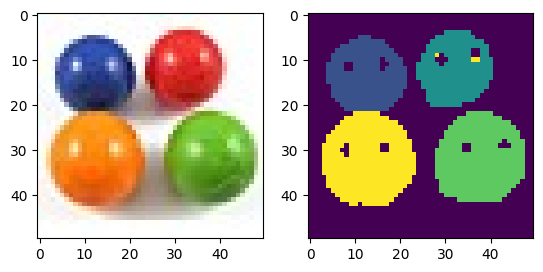

In [41]:
image_segmentation(k=50, laplacian_normalization='unn', num_classes=5, chosen_eig_indices = [0, 1, 2, 3, 4])

Failure example

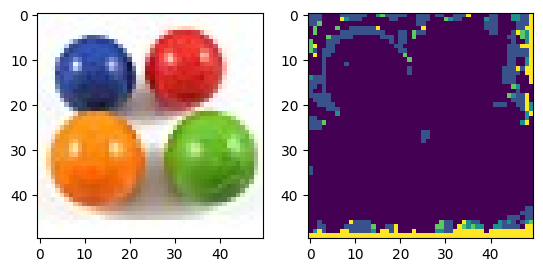

In [42]:
image_segmentation(k=20, laplacian_normalization='unn', num_classes=5, chosen_eig_indices = [0, 1, 2, 3, 4])

Success example

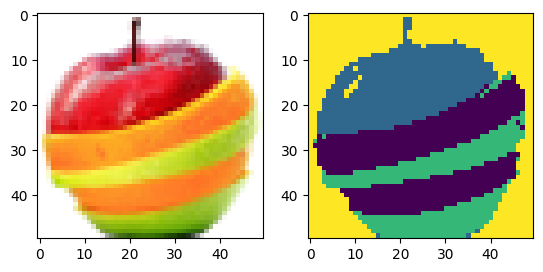

In [44]:
image_segmentation('fruit_salad.bmp', k=60, laplacian_normalization='unn', num_classes=4, chosen_eig_indices = [0, 1, 2, 3])

Failure example

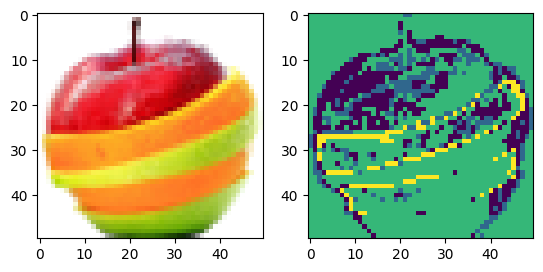

In [47]:
image_segmentation('fruit_salad.bmp', k=3, laplacian_normalization='unn', num_classes=4, chosen_eig_indices = [0, 1, 2, 3])

To do image segmentation in these two images, we used spectral clustering on these images. To do so, we import the images as tensors, we first normalize the range of the pixel values. Normalizing the pixel values ensures that all features have the same scale, which helps in stabilizing the clustering results and the similarity graph construction. Then based on this tensors, we build an associated graph, where the similarity is based on the colors of each pixel. This graph is constructed using knn-graph. The similarity graph is built based on the pixel colors and spatial proximity. The KNN graph connects each pixel to its k-nearest neighbors based on color distance. Then from this graph, we do clustering using Kmeans on the first num_classes eigenvectors of the unnormalized Laplacian. This step groups the pixels into distinct clusters based on their spectral representation, which corresponds to regions of the image that are visually similar (e.g., regions with similar colors or textures)

For the failure case, we just have to choose a small value for the number of neighbors for the k-nn graph. In this case, the associated graph cannot be a good representation of the cluster and the segmentation doesn't work well.

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

A simple idea can be to reduce the quality of the image by rescaling the image to something around $50*50$ pixels. Then, we apply spectral clustering on the small image, and we can obtain some labels. Once these labels obtained, we can upsampled them back to the original picture size like $1920*1080$ for example.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

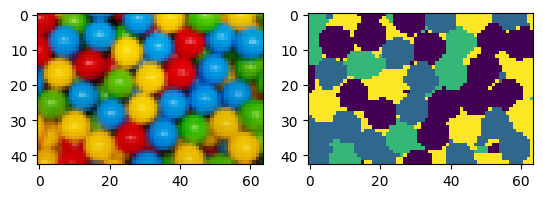

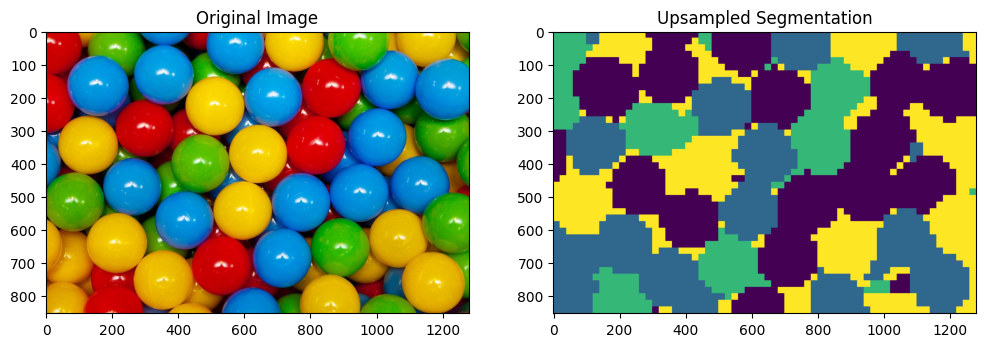

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rescale, resize
from skimage.filters import gaussian
import cv2

# Load a larger image (Full HD)
image_url = 'HD-balls.jpg'  # Replace with actual image

original_image = io.imread(image_url)
X = rescale(original_image, scale=0.05, anti_aliasing=True, channel_axis = 2)

X = (X - np.min(X)) / (np.max(X) - np.min(X))
im_side_1 = np.size(X, 1)
im_side_0 = np.size(X, 0)
Xr = X.reshape(im_side_1 * im_side_0, 3)

k = 30
W = build_similarity_graph(Xr, var=1, k=k)
L = build_laplacian(W, 'unn')
Y_rec = spectral_clustering(L, [0, 1, 2, 3], num_classes=4)

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(X)

plt.subplot(1, 2, 2)
Y_rec = Y_rec.reshape(im_side_0, im_side_1)
plt.imshow(Y_rec)

plt.show()

# Upsample the segmentation results to match the original image size
Y_rec_upsampled = resize(Y_rec, (original_image.shape[0], original_image.shape[1]), order=0, preserve_range=True, anti_aliasing=False)

# Plot the original image and the upsampled segmentation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(Y_rec_upsampled, cmap='viridis')
plt.title("Upsampled Segmentation")

plt.show()

Here I applied the simple method explained in the question 3.2. We can observe that the results are satisfying even if there are not perfect. Maybe we can apply some filters to the upsampled labels to make them smoother such that they fit more the ground truth labels from the original image.